In [1]:
# Importing all functions from .py files
from utils import *
from model import *

# Loading and preparing data to feed the model training

In [2]:
# cloning the repo with the original data to be used
!git clone https://github.com/VikramShenoy97/Human-Segmentation-Dataset

Cloning into 'Human-Segmentation-Dataset'...
remote: Enumerating objects: 596, done.
remote: Total 596 (delta 0), reused 0 (delta 0), pack-reused 596
Receiving objects: 100% (596/596), 13.60 MiB | 6.73 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [3]:
images_dir = os.getcwd() + '/Human-Segmentation-Dataset/Training_Images'
images_names = sorted(os.listdir(images_dir))
images_names = [i for i in images_names if i.split('.')[-1]=='jpg']
masks_dir = os.getcwd() + '/Human-Segmentation-Dataset/Ground_Truth'
masks_names = sorted(os.listdir(masks_dir))
masks_names = [i for i in masks_names if i.split('.')[-1]=='png']

In [4]:
# This is a small dataset - 290 images
len(images_names)

290

In [5]:
masks_dir_processed = os.getcwd() + '/Human-Segmentation-Dataset/Ground_Truth_masks_adjusted'

In [6]:
os.mkdir(masks_dir_processed)

In [7]:
# Adjusting the original dataset to match the masks and images positions for further training
adjust_masks(masks_names, masks_dir, images_dir, masks_dir_processed)

In [8]:
n = 6 #taking a few images for test predictions
proportion = 0.75 # proportion of the remaining images that will be used for the training set

# Separating images and masks files into different groups to further create the training, validation and test sets 
test_images_names = sorted(sample(images_names, n))
train_val_images_names = sorted(list(set(images_names).difference(test_images_names)))
train_images_names = sorted(sample(train_val_images_names, int(proportion*len(train_val_images_names))))
val_images_names = sorted(list(set(train_val_images_names).difference(set(train_images_names))))
train_masks_names = sorted([i.replace('jpg', 'png') for i in train_images_names.copy()])
val_masks_names = sorted([i.replace('jpg', 'png') for i in val_images_names.copy()])
test_masks_names = sorted([i.replace('jpg', 'png') for i in test_images_names.copy()])

In [9]:
# Splitting the original 290 images into training, validation and test images (unseen data)
len(train_images_names), len(val_images_names), len(test_images_names)

(213, 71, 6)

In [10]:
# Creating training and validation sets to train the model
X_train = conv_imgs_to_arrays(load_dataset(train_images_names, images_dir))
y_train = conv_imgs_to_arrays(load_dataset(train_masks_names, masks_dir_processed))
X_val = conv_imgs_to_arrays(load_dataset(val_images_names, images_dir))
y_val = conv_imgs_to_arrays(load_dataset(val_masks_names, masks_dir_processed))

# Creating and training the model

In [11]:
# Creating the model
model = model()

In [12]:
# Looking at the model architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 640, 640, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 640, 640, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 640, 640, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 640, 640, 64) 36928       activation[0][0]                 
______________________________________________________________________________________________

In [13]:
# Defining model parameters
lr = 0.0001 # model's learning rate
epochs = 30
optimizer = Adam(lr = lr, decay = lr / epochs)
callback = EarlyStopping(monitor='val_accuracy', patience=5)

In [14]:
# Compiling model
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics='accuracy')

In [15]:
# Training and saving the model metrics into history
history = model.fit(X_train, y_train, batch_size=4,
                    validation_data=(X_val, y_val), shuffle=True,
                    callbacks = [callback],
                    verbose=True, epochs=epochs)

Epoch 1/30
54/54 [==============================] - 94s 2s/step - loss: 0.4566 - accuracy: 0.8104 - val_loss: 0.3341 - val_accuracy: 0.8272
Epoch 2/30
54/54 [==============================] - 41s 757ms/step - loss: 0.3351 - accuracy: 0.8382 - val_loss: 0.2912 - val_accuracy: 0.8406
Epoch 3/30
54/54 [==============================] - 41s 759ms/step - loss: 0.2984 - accuracy: 0.8529 - val_loss: 0.2852 - val_accuracy: 0.8706
Epoch 4/30
54/54 [==============================] - 41s 760ms/step - loss: 0.2855 - accuracy: 0.8643 - val_loss: 0.2608 - val_accuracy: 0.8766
Epoch 5/30
54/54 [==============================] - 41s 760ms/step - loss: 0.2629 - accuracy: 0.8729 - val_loss: 0.2470 - val_accuracy: 0.8869
Epoch 6/30
54/54 [==============================] - 41s 761ms/step - loss: 0.2601 - accuracy: 0.8758 - val_loss: 0.2423 - val_accuracy: 0.8853
Epoch 7/30
54/54 [==============================] - 41s 761ms/step - loss: 0.2701 - accuracy: 0.8664 - val_loss: 0.2413 - val_accuracy: 0.8832
Ep

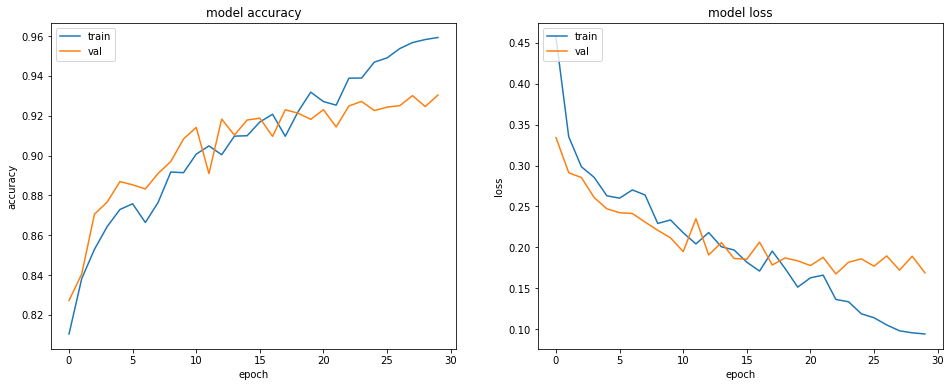

In [16]:
make_history_plots(history)

# Making inferences on unseen data using the trained model

In [17]:
# Loading test images, masks and creating the predictions using the model
X_images = load_dataset(test_images_names, images_dir)
X_test = conv_imgs_to_arrays(X_images)
y_test = load_dataset(test_masks_names, masks_dir_processed)
y_pred_images = conv_arrays_to_imgs(model.predict(X_test, batch_size=4))

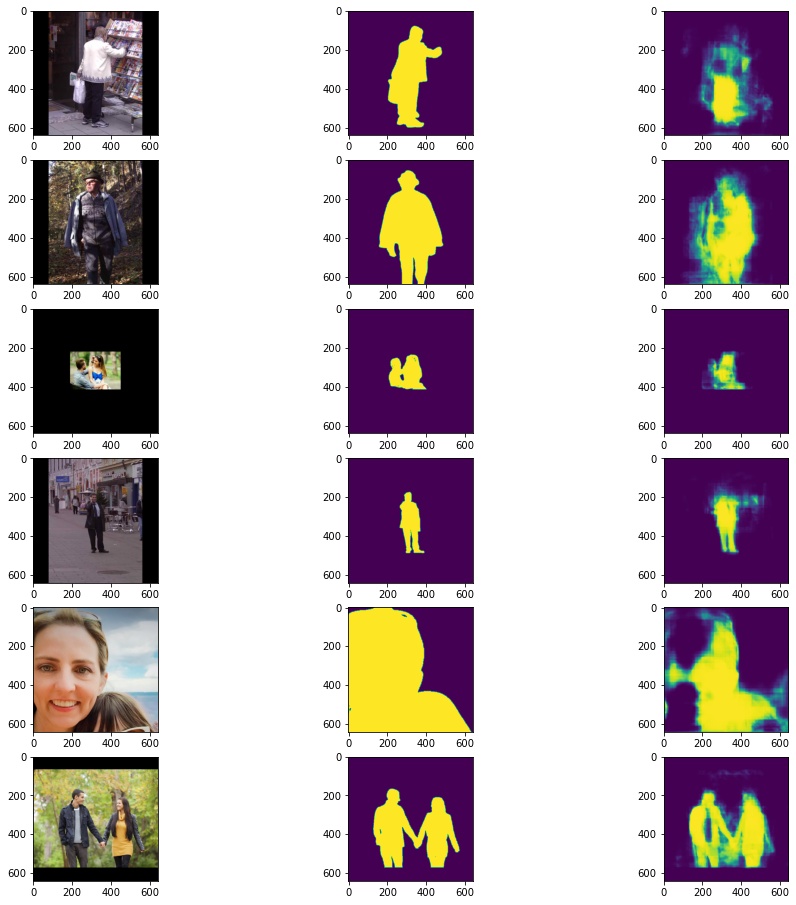

In [18]:
# Comparing original image, its original mask and the predicted mask using the trained model
fig = plt.figure(figsize=(16, 16))
for i in range(1,n+1):
    ax1 = fig.add_subplot(n,3,3*(i-1)+1)
    ax1.imshow(X_images[i-1])
    ax2 = fig.add_subplot(n,3,3*(i-1)+2)
    ax2.imshow(y_test[i-1])
    ax3 = fig.add_subplot(n,3,3*(i-1)+3)
    ax3.imshow(y_pred_images[i-1])

# Saving the model for further usage

In [19]:
model.save('unet.h5py', save_format='h5')